# Data Analysis

In [1]:
import pandas as pd
df = pd.read_csv("C:/Users/ashva/Projects/sentiment_analysis/Twitter US Airline Sentiment/Tweets.csv")

In [2]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

# Data Preprocessing

In [4]:
# splitting dataframe by row index
df_split  = df.iloc[:7320,:]
# df_split = df.sample(frac=.5)

# need the text and sentiment column.\
review_df = df_split[['text','airline_sentiment']]

print(review_df.shape)
review_df.head()

(7320, 2)


,text,airline_sentiment
8157,@JetBlue and The from @WSJ Team to Offer In-#F...,neutral
4394,@SouthwestAir @SMiles1307 over two hours now. ...,negative
7875,@JetBlue got it. Thanks,positive
12183,@americanair I sure do. I'm running version 3....,neutral
14162,@AmericanAir my husband and 5 year old son stu...,negative


In [5]:
# Check the values of the airline_sentiment column.
review_df["airline_sentiment"].value_counts()

negative    8828
neutral     3051
positive    2321
Name: airline_sentiment, dtype: int64

In [6]:
# convert the categorical values to numeric using the "factorize()" method
sentiment_label = review_df.airline_sentiment.factorize()
# sentiment_label[0].shape
# sentiment_label[1].shape
# sentiment_label[0]
# sentiment_label[1]
sentiment_label

(array([0, 1, 0, ..., 0, 1, 0], dtype=int64),
 Index(['neutral', 'positive', 'negative'], dtype='object'))

In [7]:
# retrieve all the text data from the dataset
tweet = review_df.text.values

# break down all the words/sentences of a text into small parts called tokens
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)

# create an association between the words and the assigned numbers using fit_on_texts
tokenizer.fit_on_texts(tweet)

# store associations in the form of a dictionary in the tokenizer.word_index attribute
vocab_size = len(tokenizer.word_index) + 1

# replace the words with their assigned numbers using the text_to_sequence() method
encoded_docs = tokenizer.texts_to_sequences(tweet)

# pad the sentences to have equal length
from tensorflow.keras.preprocessing.sequence import pad_sequences
def features_extractor(i_num):
    padded_sequence = pad_sequences(encoded_docs, maxlen=200)
    return padded_sequence[i_num]

In [8]:
# we need to extract the featured from all the tweets, so we use tqdm
from tqdm import tqdm

# Now we iterate through every tweet and extract features
# using Tokenizer

extracted_features=[]
for index_num,row in tqdm(review_df.iterrows()):
    final_class_labels=row["airline_sentiment"]
    data=features_extractor(index_num)
    extracted_features.append([data,final_class_labels])

14200it [34:14,  6.91it/s]


In [9]:
# converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",neutral
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",positive
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",neutral
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",negative
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",negative


# Split Processed Dataset

In [10]:
import numpy as np

# Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

# Label Encoding -> Label Encoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

label_encoder=LabelEncoder()
y=to_categorical(label_encoder.fit_transform(y))

# Train Test Split
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

# Building Text Classifier

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation, SpatialDropout1D
from tensorflow.keras.layers import Embedding

num_labels = sentiment_label[1].shape[0]
print(num_labels)

embedding_vector_length = 32

model = Sequential()

model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))

model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])

print(model.summary())

3
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          496160    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 32)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                16600     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 153       
_________________________________________________________________
activation (Activation)      (None, 3)                 0         
Total params: 512,913
Trainable params: 512,913
Non-trainable params: 0
________________________________________________

In [12]:
# Training my model
import os
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 5
num_batch_size = 32

checkpoint_path = "model/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True)

start = datetime.now()

history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[cp_callback], verbose=1)

# creates a single collection of TensorFlow checkpoint files that are updated at the end of each epoch
os.listdir(checkpoint_dir)

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('my_sen_ana_model.h5')

duration = datetime.now() - start

print("Training completed in time: ", duration)

Epoch 1/5
355/355 [==============================] - 25s 53ms/step - loss: 0.7277 - accuracy: 0.6924 - precision: 0.7971 - recall: 0.5393 - val_loss: 0.6336 - val_accuracy: 0.7215 - val_precision: 0.8183 - val_recall: 0.6011

Epoch 00001: val_loss improved from inf to 0.63361, saving model to model/training_1\cp.ckpt
INFO:tensorflow:Assets written to: model/training_1\cp.ckpt\assets
Epoch 2/5
355/355 [==============================] - 14s 40ms/step - loss: 0.5037 - accuracy: 0.8030 - precision: 0.8559 - recall: 0.7311 - val_loss: 0.5652 - val_accuracy: 0.7676 - val_precision: 0.7967 - val_recall: 0.7398

Epoch 00002: val_loss improved from 0.63361 to 0.56523, saving model to model/training_1\cp.ckpt
INFO:tensorflow:Assets written to: model/training_1\cp.ckpt\assets
Epoch 3/5
355/355 [==============================] - 13s 37ms/step - loss: 0.3809 - accuracy: 0.8567 - precision: 0.8803 - recall: 0.8278 - val_loss: 0.5505 - val_accuracy: 0.7884 - val_precision: 0.8113 - val_recall: 0.7525

In [13]:
# Evaluate the model
test_accuracy =model.evaluate(X_test,y_test,verbose=1)
print("Accuracy: {:.2f}%".format(test_accuracy[1]*100))

89/89 [==============================] - 1s 10ms/step - loss: 0.6258 - accuracy: 0.7817 - precision: 0.7979 - recall: 0.7658
Accuracy: 78.17%


In [14]:
#model.predict_classes(X_test)
import numpy as np

predict_x=model.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)
print(classes_x)

[1 0 0 ... 0 0 1]


# Visualizing the metrics

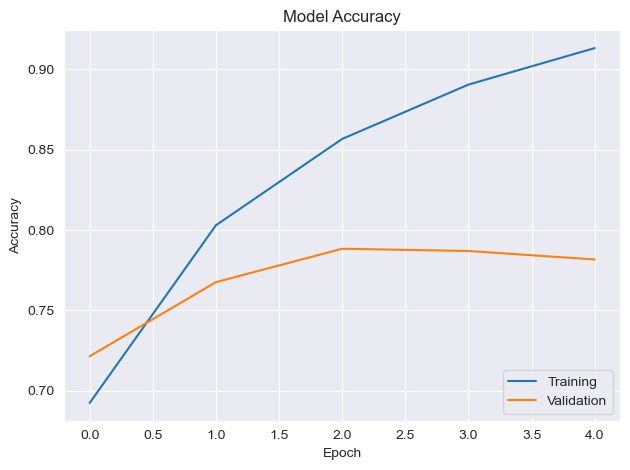

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')

plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

plt.savefig("Accuracy plot.jpg")

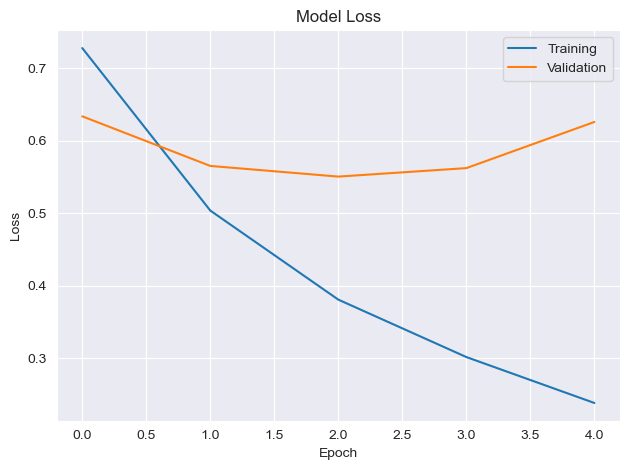

<Figure size 640x480 with 0 Axes>

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')

plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout()

plt.show()

plt.savefig("Loss plt.jpg")

<AxesSubplot: title={'center': 'Confusion Matrix for CAC w/o norm'}, xlabel='Predicted label', ylabel='True label'>

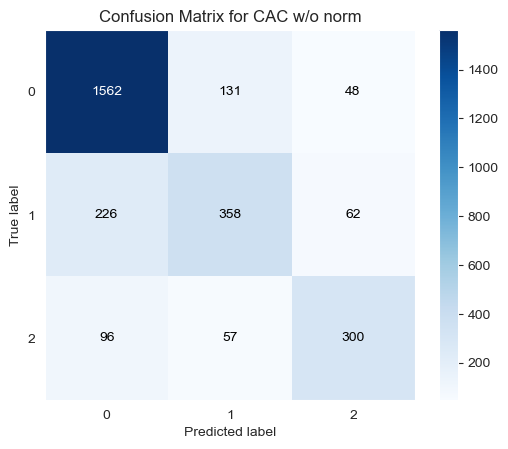

In [17]:
import scikitplot as skplt

# convert tests labels in single-digits instead of one-hot encoding!
y_test_arg=np.argmax(y_test,axis=1)
skplt.metrics.plot_confusion_matrix(y_test_arg, classes_x, normalize=False, title = 'Confusion Matrix for CAC w/o norm')

# plt.savefig("Confusion Matrix for CAC w/o norm.jpg")

<AxesSubplot: title={'center': 'Confusion Matrix for CAC with norm'}, xlabel='Predicted label', ylabel='True label'>

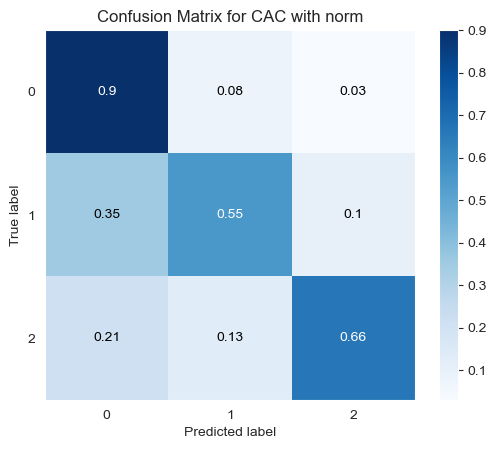

In [18]:
skplt.metrics.plot_confusion_matrix(y_test_arg, classes_x, normalize=True, title = 'Confusion Matrix for CAC with norm')

# plt.savefig("Confusion Matrix for CAC with norm.jpg")

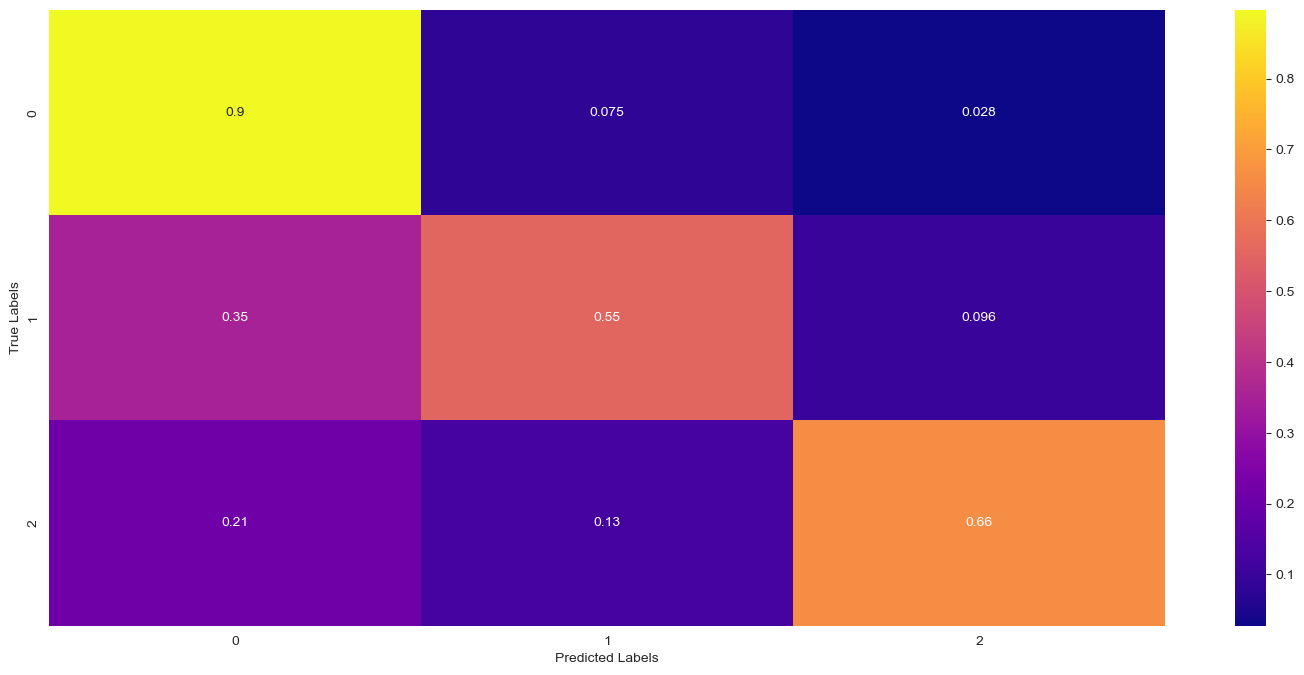

In [19]:
import seaborn as sns

plt.figure(figsize = (18,8))
sns.heatmap(skplt.metrics.confusion_matrix(y_test_arg, classes_x, normalize='true'), annot = True, cmap = 'plasma')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# plt.savefig("Confusion Matrix for CAC with norm(sns).jpg")

# Model Execution

In [20]:
import tensorflow as tf
new_model = tf.keras.models.load_model('my_sen_ana_model.h5')

from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()

import numpy as np
# from tensorflow.keras.preprocessing.sequence import pad_sequences
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    # prediction = int(model.predict(tw).round().item())
    x_predict=new_model.predict(tw)
    predicted_label=np.argmax(x_predict,axis=1)
    # print("Predicted label: ", predicted_label)
    # prediction_class = LabelEncoder.inverse_transform(predicted_label)
    return predicted_label

choice = 'y'

while 'y':
    test_sentence1 = input("Enter statement: ")
    print("Text: ", test_sentence1)
    result = predict_sentiment(test_sentence1)
    if result == [0]:
        print("Predicted label: Neutral")
    elif result == [1]:
        print("Predicted label: Positive")
    else:
        print("Predicted label: Negative")
    choice = input("Continue (y/n) ?")
    if choice == 'n':
        break

Text:  This is the best airline ever!
Predicted label: Positive
